# Logistic Regression

In [1]:
#!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [11]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)

In [12]:
accidents.head(2)

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,is_non_functioning_device,has_no_controls,is_day,is_evening,is_morning,is_night,is_fall,is_spring,is_summer,is_winter
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,1,1,0,0,0,0,0,1,0
5,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,0,0,0,0,1,0,1,0,0


## Process Data for Model

In [13]:
X = accidents[['is_pedestrian',
               'has_stop_sign_or_traffic_light',
               'is_parked',
               'has_no_controls',
               'is_cyclist',
               'POSTED_SPEED_LIMIT',
               'is_night',
               'is_winter',
               'is_fall',
               'is_weekend',
               'is_clear_weather',
               'is_rain',
               'is_evening']]



y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [14]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
oversampler = SMOTE(sampling_strategy=0.75, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [16]:
solvers = ['saga', 'newton-cg', 'lbfgs', 'liblinear']
penalties = ['l1', 'l2']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(C=c_values, penalty=penalties, solver=solvers)

In [17]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/s

In [18]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Optimal Penalty: ', best_model.best_estimator_.get_params()['penalty'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  newton-cg
Optimal Penalty:  l2
Best C:  100


### Train and Predict

In [19]:
penalty = 'l2'
solver='newton-cg'
c=100

log_reg = LogisticRegression(penalty=penalty, solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[51459  6091]
 [  597   468]]


Recall (Scores FN):  0.4394
Precision (Scores FP):  0.0714
AUC Score:  0.7403


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


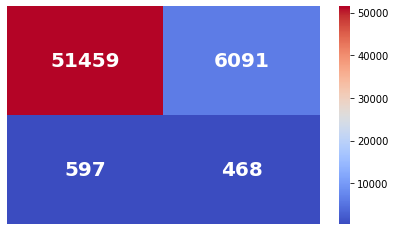

In [20]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [21]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
5,POSTED_SPEED_LIMIT,3.687097
0,is_pedestrian,2.710577
4,is_cyclist,2.034370
6,is_night,0.545324
11,is_rain,0.481288
10,is_clear_weather,0.355481
1,has_stop_sign_or_traffic_light,0.350971
9,is_weekend,0.157339
3,has_no_controls,0.152980
12,is_evening,0.018627


In [22]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -2.7811623998758814


### Test for Multicolinearity

In [23]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='newton')
results.summary()

Optimization terminated successfully.
         Current function value: 0.570042
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               402531
Model:                          Logit   Df Residuals:                   402517
Method:                           MLE   Df Model:                           13
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                  0.1653
Time:                        00:28:44   Log-Likelihood:            -2.2946e+05
converged:                       True   LL-Null:                   -2.7489e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7812      0.031    -88.783      0.000      -2.843      -2.720
x1             2.7106      0.015    176.707      0.000       2.681       2.741
x2             0.3510      0.018     19.026      0.000       0.315       0.387
x3            -0.9089      0.012    -74.539      0.000      -0.933      -0.885
x4             0.1530      0.018      8.314      0.000       0.117       0.189
x5             2.0344      0.020    100.512      0.000       1.995       2.074
x6             3.6872      0.054     67.958      0.000       3.581       3.794
x7             0.5453      0.009     57.953      0.000       0.527       0.564
x8            -0.0329      0.009     -3.667      0.000      -0.051      -0.015
x9             0.0065      0.009      0.764      0.445      -0.010       0.023
x10            0.1573      0.008     19.425      0.000       0.141       0.173
x11            0.3555      0.012     28.588      0.000       0.331       0.380
x12            0.4813      0.016     29.821      0.000       0.450       0.513
x13            0.0186      0.011      1.773      0.076      -0.002       0.039
==============================================================================
"""

In [24]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)

,features,VIF
0,is_pedestrian,1.180316
1,has_stop_sign_or_traffic_light,7.817004
2,is_parked,1.364307
3,has_no_controls,9.041611
4,is_cyclist,1.073689
5,POSTED_SPEED_LIMIT,15.506655
6,is_night,1.338168
7,is_winter,1.675225
8,is_fall,1.709837
9,is_weekend,1.428891
